In [1]:
import netsquid as ns

## Channels

In [3]:
from netsquid.components import Channel, QuantumChannel
ns.sim_reset()
channel = Channel(name = "MyChannel")

In [4]:
# .send() methoed to send in one direction from input port to output port at other end
channel.send("hello world")
ns.sim_run()

SimStats()

since channels subclass of Entity and schedule events to trasmit message,
must run the simular for the message to arrive
.receive() method retruns messages on the ouptut, as well as the time messages have been travelling thorugh teh channel<br>
since did not specify transmission delay model for channel, ns defaults to no delay (instant retrieval of message)

In [5]:
items, delay = channel.receive()
print(items)
print(delay)

['hello world']
0.0


ways of adding delay to channel:
1. initalize channel with fixed delay
2. specify DelayModel, a subclass of Model base class
    - component's models are stored in its models map and indexed with the appropriate key (so possible to give distrionary with models at initalization if preferred)
    - ex: Gaussian delay model (samples from normal distribution)
    - ex: FibreDelayModel models delay present in fibre optic cables

In [6]:
# fixed delay
Channel(name="DelayChannel", delay=10)

Channel(name='DelayChannel')

In [7]:
# predefined fixed delay model
from netsquid.components.models.delaymodels import FixedDelayModel
fixed_delaymodel = FixedDelayModel(delay = 10)

channel.models['delay_model'] = fixed_delaymodel
channel.send("hello world!")
ns.sim_run()
channel.receive()

(['hello world!'], 10.0)

In [8]:
# Gaussion delay model
from netsquid.components.models.delaymodels import GaussianDelayModel
gaussian_delaymodel = GaussianDelayModel(delay_mean=5, delay_std=0.1)

In [9]:
#fibe optic model
Channel("TutorialChannel", length=10)
channel.properties['length'] = 10
from netsquid.components.models.delaymodels import FibreDelayModel
delay_model = FibreDelayModel()
print(f"Speed of light in fibre: {delay_model.properties['c']:.1f} [km/s]")
delay_model.required_properties

Speed of light in fibre: 200000.0 [km/s]


['length']

not only want to send classical messages, also want to naturally transmit qubits (Qubit), so need our channel to mdoel transmission delay + quantum noise (attenuation) and the channel's physical characteristics<br>
quantum channel (QuantumChannel) intended for transmission of qubits<br>
in additon to transmission delay it also models (QuantumErrorModel):
- quantum_noise_model: models noise experienced by qubits during their transmission; applied just before it is received
- quantum_loss_model: determines whether the transmitted qubits are lost; applied just before it is transmitted
<br>

In [10]:
from netsquid.components.models.qerrormodels import FibreLossModel
from netsquid.components.qchannel import QuantumChannel
loss_model = FibreLossModel(p_loss_init=0.83, p_loss_length = 0.2)
qchannel = QuantumChannel("MyQChannel", length=20, models={'quantum_loss_model': loss_model})

## Quantum Memory

In [11]:
# for depolarize noise model
from netsquid.components import QuantumMemory
qmem = QuantumMemory(name="MyMemory", num_positions =1)

from netsquid.components.models.qerrormodels import DepolarNoiseModel
depolar_noise = DepolarNoiseModel(depolar_rate=1e6) #depolar rate in Hz

In [12]:
#quantum memory can have muiltiple memory positions, each assigned its own error model
qmem = QuantumMemory("DepolarMemory", num_positions=2, memory_noise_models=[depolar_noise, depolar_noise])
for mem_pos in qmem.mem_positions:
    mem_pos.models['noise_model'] = depolar_noise

In [13]:
# .put() method inserts a qubit into a quantum memory
# .pop() ethod to get qubit out from memory
# .peek() if want to verify that qubit exists at that memory position

from netsquid.qubits.qubitapi import create_qubits
qubits = create_qubits(1)
qmem.put(qubits)
qmem.peek(0)

[Qubit('QS#0-0')]

In [14]:
qmem.peek(0)

[Qubit('QS#0-0')]

In [15]:
qmem.pop(positions=0)

[Qubit('QS#0-0')]

In [16]:
qmem.peek(0)

[None]

In [17]:
# operating direclty on qubits in quantum memory
import netsquid.qubits.operators as ops
qmem.put(qubits)
qmem.operate(ops.X, positions=[0])

In [18]:
# quantum memory can also measure qubits
qmem.measure(positions=[0])

([1], [1.0])

In [19]:
# changing measurement basis, thus inherently also the probability of measuring that quibt
qmem.measure(positions=[0], observable=ops.X)

([1], [0.4999999999999998])

## Ports

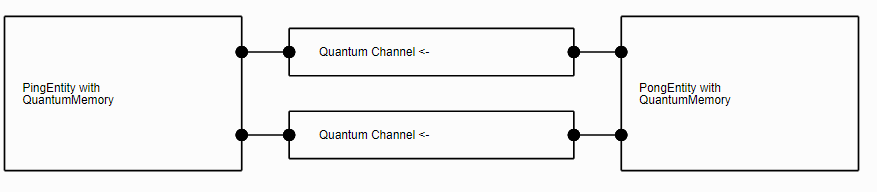

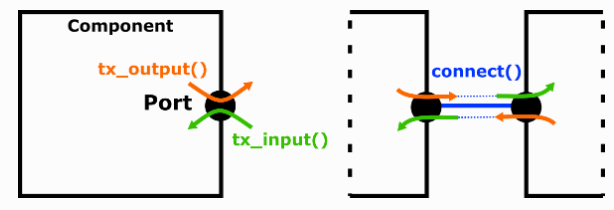

In [20]:
# send() and receive() from Channel class conveneiven method that make use of send and rev ports on a channel
# thus also possible to do:
channel = Channel("TutorialChannel", delay=3)
channel.ports['send'].tx_input("hello")
ns.sim_run()
channel.ports['recv'].rx_output()

Message(items=['hello'], header=None, ch_delta_time=3.0)

alternative to put() is tos end a message containing a list of qubits to the qin port of the quantum meomry, or
a message witha singel qubit to a specific qinX prt, where X is the index of a specific memory postion

In [21]:
channel.ports['recv'].connect(qmem.ports['qin0'])

In [22]:
qubit, = create_qubits(1)
print(qubit)
channel.send(qubit)
ns.sim_run()
qmem.peek(0)

Qubit('QS#1-0')


[Qubit('QS#1-0')]

## Ping Pong using components and ports

In [23]:
ns.sim_reset()

In [24]:
from netsquid.components.component import Port
import pydynaa

class PingEntity(pydynaa.Entity):
    length = 2e-3  # channel length [km]

    def __init__(self):
        # Create a memory and a quantum channel:
        self.qmemory = QuantumMemory("PingMemory", num_positions=1)
        self.qchannel = QuantumChannel("PingChannel", length=self.length,
                                       models={"delay_model": FibreDelayModel()})
        # link output from qmemory (pop) to input of ping channel:
        self.qmemory.ports["qout"].connect(self.qchannel.ports["send"])
        # Setup callback function to handle input on quantum memory port "qin0":
        self._wait(pydynaa.EventHandler(self._handle_input_qubit),
                   entity=self.qmemory.ports["qin0"], event_type=Port.evtype_input)
        self.qmemory.ports["qin0"].notify_all_input = True

    def start(self, qubit):
        # Start the game by having ping player send the first qubit (ping)
        self.qchannel.send(qubit)

    def wait_for_pong(self, other_entity):
        # Setup this entity to pass incoming qubits to its quantum memory
        self.qmemory.ports["qin0"].connect(other_entity.qchannel.ports["recv"])

    def _handle_input_qubit(self, event):
        # Callback function called by the pong handler when pong event is triggered
        [m], [prob] = self.qmemory.measure(positions=[0], observable=ns.Z)
        labels_z = ("|0>", "|1>")
        print(f"{ns.sim_time():.1f}: Pong event! PingEntity measured "
              f"{labels_z[m]} with probability {prob:.2f}")
        self.qmemory.pop(positions=[0])
                    
class PongEntity(pydynaa.Entity):
    length = 2e-3  # channel length [km]

    def __init__(self):
        # Create a memory and a quantum channel:
        self.qmemory = QuantumMemory("PongMemory", num_positions=1)
        self.qchannel = QuantumChannel("PingChannel", length=self.length,
                                       models={"delay_model": FibreDelayModel()})
        # link output from qmemory (pop) to input of ping channel:
        self.qmemory.ports["qout"].connect(self.qchannel.ports["send"])
        # Setup callback function to handle input on quantum memory:
        self._wait(pydynaa.EventHandler(self._handle_input_qubit),
                   entity=self.qmemory.ports["qin0"], event_type=Port.evtype_input)
        self.qmemory.ports["qin0"].notify_all_input = True

    def wait_for_ping(self, other_entity):
        # Setup this entity to pass incoming qubits to its quantum memory
        self.qmemory.ports["qin0"].connect(other_entity.qchannel.ports["recv"])

    def _handle_input_qubit(self, event):
        # Callback function called by the pong handler when pong event is triggered
        [m], [prob] = self.qmemory.measure(positions=[0], observable=ns.X)
        labels_x = ("|+>", "|->")
        print(f"{ns.sim_time():.1f}: Ping event! PongEntity measured "
              f"{labels_x[m]} with probability {prob:.2f}")
        self.qmemory.pop(positions=[0])

In [25]:
ns.sim_reset()
ping = PingEntity()
pong = PongEntity()
ping.wait_for_pong(pong)
pong.wait_for_ping(ping)
#create qubit and instruct ping entity to start
qubit, = ns.qubits.create_qubits(1)
ping.start(qubit)
ns.set_random_state(seed=42)
stats = ns.sim_run(91)

10.0: Ping event! PongEntity measured |+> with probability 0.50
20.0: Pong event! PingEntity measured |1> with probability 0.50
30.0: Ping event! PongEntity measured |-> with probability 0.50
40.0: Pong event! PingEntity measured |1> with probability 0.50
50.0: Ping event! PongEntity measured |+> with probability 0.50
60.0: Pong event! PingEntity measured |0> with probability 0.50
70.0: Ping event! PongEntity measured |+> with probability 0.50
80.0: Pong event! PingEntity measured |1> with probability 0.50
90.0: Ping event! PongEntity measured |-> with probability 0.50


## Quantum teleportation using components

In [26]:
ns.set_qstate_formalism(ns.QFormalism.DM)
ns.sim_reset()

In [27]:
class Alice(pydynaa.Entity):
    def __init__(self, teleport_state, cchannel_send_port):
        self.teleport_state = teleport_state
        self.cchannel_send_port = cchannel_send_port
        self.qmemory = QuantumMemory("AliceMemory", num_positions=2)
        self._wait(pydynaa.EventHandler(self._handle_input_qubit),
                   entity=self.qmemory.ports["qin1"], event_type=Port.evtype_input)
        self.qmemory.ports["qin1"].notify_all_input = True

    def _handle_input_qubit(self, event):
        # Callback function that does teleportation and
        # schedules a corrections ready event
        q0, = ns.qubits.create_qubits(1, no_state=True)
        ns.qubits.assign_qstate([q0], self.teleport_state)
        self.qmemory.put([q0], positions=[0])
        self.qmemory.operate(ns.CNOT, positions=[0, 1])
        self.qmemory.operate(ns.H, positions=[0])
        m0, m1 = self.qmemory.measure(positions=[0, 1], observable=ns.Z,
                                      discard=True)[0]
        self.cchannel_send_port.tx_input([m0, m1])
        print(f"{ns.sim_time():.1f}: Alice received entangled qubit, "
              f"measured qubits & sending corrections")

class Bob(pydynaa.Entity):
    depolar_rate = 1e7  # depolarization rate of waiting qubits [Hz]

    def __init__(self, cchannel_recv_port):
        noise_model = DepolarNoiseModel(depolar_rate=self.depolar_rate)
        self.qmemory = QuantumMemory("BobMemory", num_positions=1,
                                     memory_noise_models=[noise_model])
        cchannel_recv_port.bind_output_handler(self._handle_corrections)

    def _handle_corrections(self, message):
        # Callback function that handles messages from both Alice and Charlie
        m0, m1 = message.items
        if m1:
            self.qmemory.operate(ns.X, positions=[0])
        if m0:
            self.qmemory.operate(ns.Z, positions=[0])
        qubit = self.qmemory.pop(positions=[0])
        fidelity = ns.qubits.fidelity(qubit, ns.y0, squared=True)
        print(f"{ns.sim_time():.1f}: Bob received entangled qubit and corrections!"
              f" Fidelity = {fidelity:.3f}")

can automate Charlie using component of QSource, which will be connected to Alice and Bob using quantum channels
<br>
Quantum soruce any componetsn that can generate one or more qubits in speicifc or random sampled quantum state
<br>
Statesampler initialised with a list of states and a list of matching probabiliteis
<br>

sample() method used to get a random state form this list.
<br>
we always want entangled bell state |B<sub>00</sub>>, which can be represented as b00 in netsquid

In [28]:
from netsquid.qubits.state_sampler import StateSampler
import netsquid.qubits.ketstates as ks
state_sampler = StateSampler([ks.b00], [1.0])

In [29]:
#since want to have two genreated qubits go in different directions, must specify two output ports to quantum soruce consturcotr
from netsquid.components.qsource import QSource, SourceStatus
charlie_source = QSource("Charlie", state_sampler, frequency=100, num_ports =2, timing_model=FixedDelayModel(delay=50), status=SourceStatus.INTERNAL)

The quantum source can be in one of three modes specified by the SourceStatus enumerator: OFF (the default), INTERNAL, and EXTERNAL. In the internal mode the source operates using its internal clock component (Clock), which can be initialised using the frequency or timing_model parameters. In the external mode the source waits to be externally triggered by receiving any message on its trigger port. We can also call trigger() manually to emulate a trigger message arriving on the port. In the example above we have chosen to use the internal clock with a delay of 50 ns (frequency of 20 GHz).

In [30]:
def setup_network(alice,bob,qsource,length=4e-3):
    qchannel_c2a = QuantumChannel("Charlie->Alice", length=length/2, models={"delay_model": FibreDelayModel()})
    qchannel_c2b = QuantumChannel("Charlie->Bob", legnth=length/2, models={"delay_model": FibreDelayModel()})
    qsource.ports['qout0'].connect(qchannel_c2a.ports['send'])
    qsource.ports['qout1'].connect(qchannel_c2b.ports['send'])
    alice.qmemory.ports['qin1'].connect(qchannel_c2a.ports['recv'])
    bob.qmemory.ports['qin0'].connect(qchannel_c2b.ports['recv'])

In [31]:
# create Alice and Bob entties and connect classically togehtr
from netsquid.components import ClassicalChannel
cchannel = ClassicalChannel("CChannel", length=4e-3, models={"delay_mode": FibreDelayModel()})
alice = Alice(teleport_state=ns.y0, cchannel_send_port=cchannel.ports["send"])
bob = Bob(cchannel_recv_port=cchannel.ports["recv"])
setup_network(alice,bob,charlie_source)
stats = ns.sim_run(end_time=200)

10.0: Alice received entangled qubit, measured qubits & sending corrections
10.0: Bob received entangled qubit and corrections! Fidelity = 0.952
60.0: Alice received entangled qubit, measured qubits & sending corrections
60.0: Bob received entangled qubit and corrections! Fidelity = 0.952
110.0: Alice received entangled qubit, measured qubits & sending corrections
110.0: Bob received entangled qubit and corrections! Fidelity = 0.952
160.0: Alice received entangled qubit, measured qubits & sending corrections
160.0: Bob received entangled qubit and corrections! Fidelity = 0.952


main advantage of using components than what we did before, is that noise is automatically handled by quantum memories